<a href="https://colab.research.google.com/github/ChristophWuersch/AppliedNeuralNetworks/blob/main/solutions/tfrecord_gdrive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to train a Keras model on TFRecord files

**Author:** Amy MiHyun Jang<br>
**Date created:** 2020/07/29<br>
**Last modified:** 2020/08/07<br>
**Description:** Loading TFRecords for computer vision models.

## Introduction + Set Up

TFRecords store a sequence of binary records, read linearly. They are useful format for
storing data because they can be read efficiently. Learn more about TFRecords
[here](https://www.tensorflow.org/tutorials/load_data/tfrecord).

We'll explore how we can easily load in TFRecords for our melanoma classifier.

In [1]:
import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Number of replicas: 1


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


We want a bigger batch size as our data is not balanced.

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
GCS_PATH = "/content/gdrive/My Drive/ANN_Data/Melanoma"
BATCH_SIZE = 32
IMAGE_SIZE = [1024, 1024]

In [4]:
import os
os.listdir(GCS_PATH+'/tfrecords')

['test00-687.tfrec',
 'test01-687.tfrec',
 'test02-687.tfrec',
 'test03-687.tfrec',
 'test04-687.tfrec',
 'test05-687.tfrec',
 'test06-687.tfrec',
 'test07-687.tfrec',
 'test08-687.tfrec',
 'test09-687.tfrec',
 'test10-687.tfrec',
 'test11-687.tfrec',
 'test12-687.tfrec',
 'test13-687.tfrec',
 'test14-687.tfrec',
 'test15-677.tfrec',
 'train00-2071.tfrec',
 'train01-2071.tfrec',
 'train02-2071.tfrec',
 'train03-2071.tfrec',
 'train04-2071.tfrec',
 'train05-2071.tfrec',
 'train06-2071.tfrec',
 'train07-2071.tfrec',
 'train08-2071.tfrec',
 'train09-2071.tfrec',
 'train10-2071.tfrec',
 'train11-2071.tfrec',
 'train12-2071.tfrec',
 'train13-2071.tfrec',
 'train14-2071.tfrec',
 'train15-2061.tfrec']

## Load the data

In [5]:
FILENAMES = tf.io.gfile.glob(GCS_PATH + "/tfrecords/train*.tfrec")
split_ind = int(0.9 * len(FILENAMES))
TRAINING_FILENAMES, VALID_FILENAMES = FILENAMES[:split_ind], FILENAMES[split_ind:]

TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + "/tfrecords/test*.tfrec")
print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))
print("Test TFRecord Files:", len(TEST_FILENAMES))

Train TFRecord Files: 14
Validation TFRecord Files: 2
Test TFRecord Files: 16


### Decoding the data

The images have to be converted to tensors so that it will be a valid input in our model.
As images utilize an RBG scale, we specify 3 channels.

We also reshape our data so that all of the images will be the same shape.

In [6]:

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image


As we load in our data, we need both our `X` and our `Y`. The X is our image; the model
will find features and patterns in our image dataset. We want to predict Y, the
probability that the lesion in the image is malignant. We will to through our TFRecords
and parse out the image and the target values.

In [7]:

def read_tfrecord(example, labeled):
    tfrecord_format = (
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.int64),
        }
        if labeled
        else {"image": tf.io.FixedLenFeature([], tf.string),}
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])
    if labeled:
        label = tf.cast(example["target"], tf.int32)
        return image, label
    return image


### Define loading methods

Our dataset is not ordered in any meaningful way, so the order can be ignored when
loading our dataset. By ignoring the order and reading files as soon as they come in, it
will take a shorter time to load the data.

In [8]:

def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset


We define the following function to get our different datasets.

In [9]:

def get_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.shuffle(1024)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset


### Visualize input images

In [10]:
train_dataset = get_dataset(TRAINING_FILENAMES,labeled=True)
valid_dataset = get_dataset(VALID_FILENAMES,labeled=True)
test_dataset = get_dataset(TEST_FILENAMES, labeled=False)

train_dataset



<BatchDataset shapes: ((None, 1024, 1024, 3), (None,)), types: (tf.float32, tf.int32)>

In [11]:
iter(train_dataset)

In [ ]:

image_batch, label_batch = next(iter(train_dataset))


In [42]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255.0)
        if label_batch[n]:
            plt.title("MALIGNANT")
        else:
            plt.title("BENIGN")
        plt.axis("off")


show_batch(image_batch.numpy(), label_batch.numpy())

AttributeError: ignored

TypeError: ignored

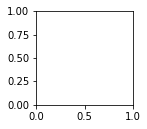

In [58]:
def show_batch_nolabel(image_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255.0)

        plt.axis("off")


show_batch_nolabel(image_batch)

## Building our model

### Define callbacks

The following function allows for the model to change the learning rate as it runs each
epoch.

We can use callbacks to stop training when there are no improvements in the model. At the
end of the training process, the model will restore the weights of its best iteration.

In [ ]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "melanoma_model.h5", save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

### Build our base model

Transfer learning is a great way to reap the benefits of a well-trained model without
having the train the model ourselves. For this notebook, we want to import the Xception
model. A more in-depth analysis of transfer learning can be found
[here](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/).

We do not want our metric to be ```accuracy``` because our data is imbalanced. For our
example, we will be looking at the area under a ROC curve.

In [ ]:

def make_model():
    base_model = tf.keras.applications.Xception(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet"
    )

    base_model.trainable = False

    inputs = tf.keras.layers.Input([*IMAGE_SIZE, 3])
    x = tf.keras.applications.xception.preprocess_input(inputs)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(8, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=tf.keras.metrics.AUC(name="auc"),
    )

    return model


## Train the model

In [ ]:
with strategy.scope():
    model = make_model()

history = model.fit(
    train_dataset,
    epochs=2,
    validation_data=valid_dataset,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

## Predict results

We'll use our model to predict results for our test dataset images. Values closer to `0`
are more likely to be benign and values closer to `1` are more likely to be malignant.

In [ ]:

def show_batch_predictions(image_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255.0)
        img_array = tf.expand_dims(image_batch[n], axis=0)
        plt.title(model.predict(img_array)[0])
        plt.axis("off")


image_batch = next(iter(test_dataset))

show_batch_predictions(image_batch)